# JaxRK hyperparameter optimization using FLAX


In [1]:
%autoreload 2
import jax.numpy as np, pylab as pl
import jax
from jaxrk.rkhs import Cdo, Cmo, LinOp, FiniteVec, FiniteOp, inner, CovOp, Cov_solve, Cov_inv
from jaxrk.kern import (GenGaussKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.reduce import *
from jax import random
import flax.linen as nn


key1, key2 = random.split(random.PRNGKey(0))

### Conditonal density estimates using the CDO

In what follows, we will create a simple data set and do conditional density estimates for it using the  [conditional density operator (CDO)](https://arxiv.org/abs/1905.11255).

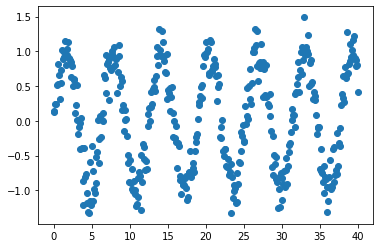

In [2]:
from numpy.random import randn
from jax import random

x = np.linspace(0, 40, 400).reshape((-1, 1))
rng_key = random.PRNGKey(0)
y = np.sin(x) + random.normal(rng_key, (len(x), 1))* 0.2

pl.scatter(x.T, y.T)

In [3]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)

Now, lets build a simple model regressing from index to output distribution using the prior information that the output depends periodically on the input. This is encoded in the fact that the input features use a periodic kernel.

In [4]:
from jaxrk.utilities.distances import rkhs_cdist

In [5]:
class Cmo_hyperparam(nn.Module):
    inp_batch:np.ndarray
    out_batch:np.ndarray

    def setup(self):        
        ok_par = self.param("ok_par", lambda rng, shape: random.normal(rng, shape), (2,))
        vec_o = FiniteVec(GenGaussKernel.make_unconstr(ok_par[:-1], ok_par[-1]),
                          self.out_batch)

        ik_par = self.param("ik_par", lambda rng, shape: random.normal(rng, shape), (2,))
        vec_i = FiniteVec(PeriodicKernel.make_unconstr(ik_par[0], ik_par[1]),
                          self.inp_batch)

        op_matr = self.param("op_matr", lambda rng, shape: Cmo(vec_i, vec_o).matr, [len(vec_i)] * 2)
        self.O = FiniteOp(vec_i, vec_o, op_matr)
    
    def __matmul__(self, other):
        return self.O @ other
    
    def get_operator(self):
        return self.O

    def loss_rkhsdist(self, inp:np.ndarray, out:np.ndarray):
        return np.trace(rkhs_cdist(FiniteVec(self.O.outp_feat.k, out), self@inp, 1))

model = Cmo_hyperparam(inp_batch = x[:199], out_batch=y[:199])
params = model.init(random.PRNGKey(0), x[199:], y[199:], method=model.loss_rkhsdist)
jax.tree_map(lambda x: x.shape, params)


FrozenDict({
    params: {
        ik_par: (2,),
        ok_par: (2,),
        op_matr: (199, 199),
    },
})

In [6]:
loss = (lambda p: model.apply(p, x[199:], y[199:], method=model.loss_rkhsdist))
alpha = 0.0003 # Gradient step size
#print('Loss for "true" W,b: ', loss(true_params))
grad_fn = jax.value_and_grad(loss)

for i in range(101):
  # We perform one gradient update
  loss_val, grad = grad_fn(params)
  params = jax.tree_multimap(lambda old, grad: old - alpha * grad,
                            params, grad)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)

Loss step 0:  93.25162
Loss step 10:  399.17493
Loss step 20:  333.96603
Loss step 30:  305.42526
Loss step 40:  287.12183
Loss step 50:  272.44473
Loss step 60:  259.1517
Loss step 70:  246.41476
Loss step 80:  234.01215
Loss step 90:  221.98679
Loss step 100:  210.49257


<Figure size 432x288 with 0 Axes>

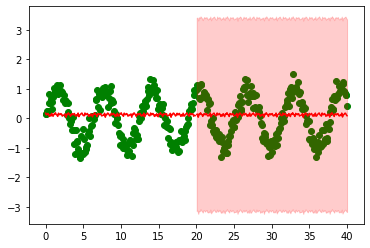

<Figure size 432x288 with 0 Axes>

In [11]:
op = model.apply(params, method=model.get_operator)
mv = np.array((op@ FiniteVec(op.inp_feat.k, x)).get_mean_var()).T
plot_pred(mv[199:399,:], x, y)
pl.plot(x[:199], mv[:199, 0], "r")
pl.figure()

Now lets say we have 10 observations per input location. This is easily reflected by using more complex RKHS elements as output feature vectors.

In [14]:
y2 = (np.sin(x) + randn(len(x) *10).reshape((-1, 10)) * 0.2).reshape((-1, 1))
outvec2 = FiniteVec(out_kern, y2[:2000], [BalancedRed(10, average=True)])

Lets compute conditional density estimates again.

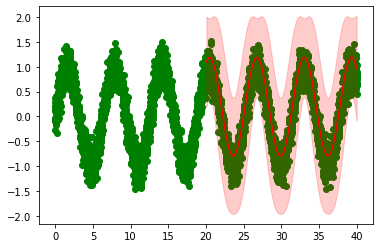

In [15]:
cd = Cdo(invec, outvec2, refervec)
mean_var = np.array((cd @ FiniteVec(invec.k, x[199:399])).get_mean_var()).T

mean_var.shape
plot_pred(mean_var, x, y2, points_per_split = 10)